In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# CNN keras
import tensorflow
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the train set with labels --> the mnist numbers dataset
# One row is on image

df = pd.read_csv('train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Divide the train set into data and labels sets

# Since it is transfer learning, we only want to use a part of the data
# The purpose is to have a smaller amount of data and still train a model.
nbr_rows = 10000

X_train = df.iloc[0:nbr_rows,1:786]
y_train = df.iloc[0:nbr_rows,0]
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


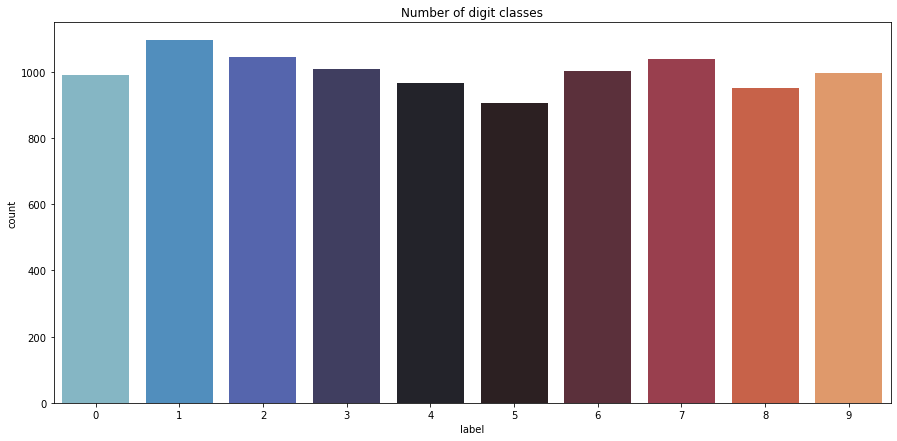

In [4]:
# Alt1
# Plot the distribution of labels (classes)
# The classes is somewhat equaly distributed

plt.figure(figsize=(15,7))
sns.countplot(y_train, palette='icefire')
plt.title('Number of digit classes')
plt.show()

# Alt 2
# y_train.value_counts()

(784,)
(28, 28)


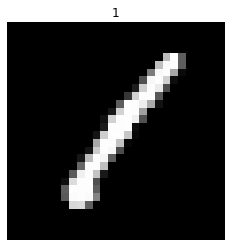

In [5]:
# View one of the images in the training set
# Must reshape the image to view it

image = X_train.iloc[0].to_numpy()
print(image.shape)
image = image.reshape(28,28)
print(image.shape)

plt.imshow(image, cmap='gray')
plt.title(df.iloc[0,0])
plt.axis("off")
plt.show()


(784,)
(28, 28)


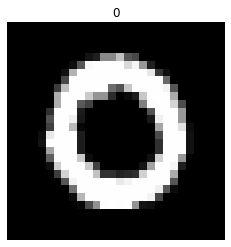

In [6]:
# View another image

image = X_train.iloc[1].to_numpy()
print(image.shape)
image = image.reshape(28,28)
print(image.shape)

plt.imshow(image, cmap='gray')
plt.title(df.iloc[1,0])
plt.axis("off")
plt.show()

In [7]:
# Load the test set

X_test = pd.read_csv('test.csv')

# Normalization of the train and the test sets

X_test = X_test / 255
X_train = X_train / 255


In [8]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


In [9]:
# x = resize(X_train[0], (96, 96),
#         mode='constant',
#         anti_aliasing=False)

In [10]:
from skimage.transform import resize

# The data must fit the mobilenet model

target_size = 96

def preprocess_image(x):
    # Resize the image to have the shape of (96,96)
    x = resize(x, (target_size, target_size),
            mode='constant',
            anti_aliasing=False)
    
    # convert to 3 channel (RGB)
    x = np.stack((x,)*3, axis=-1) 
    
    # Make sure it is a float32, here is why 
    # https://www.quora.com/When-should-I-use-tf-float32-vs-tf-float64-in-TensorFlow
    return x.astype(np.float32)

In [11]:
# Tranform the data so it fits the mobilenet model

X_train = [preprocess_image(im) for im in X_train]
X_test = [preprocess_image(im) for im in X_test]

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(10000, 96, 96, 3)
(28000, 96, 96, 3)


In [13]:
# One hot encoding the labels of the training set

y_train = to_categorical(y_train, num_classes = 10)
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [14]:
# Split the training data into a training and a validation set
# We must have validation set during the training of the CNN

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

x_train shape (9000, 96, 96, 3)
x_test shape (1000, 96, 96, 3)
y_train shape (9000, 10)
y_test shape (1000, 10)


In [15]:
# The mobilenet model with pre-trained weights from imagenet

base_model = MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(1024,activation='relu')(x) #dense layer 2
x = Dense(512,activation='relu')(x) #dense layer 3
preds = Dense(10,activation='softmax')(x) #final layer with softmax activation

In [16]:
model = Model(inputs=base_model.input,outputs=preds)

In [17]:
# View the layers of the model

# for i,layer in enumerate(model.layers):
#   print(i,layer.name)

In [18]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [19]:
# Defining nbr of epochs and batch_size for training

epochs = 10
batch_size = 250

In [20]:
# Data augmentation; move and rotate the data

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [21]:
# Compile the model

model.compile(optimizer = Adam(lr = 0.001 , beta_1 = 0.9, beta_2 = 0.999),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

In [22]:
steps_per_epoch = X_train.shape[0] / batch_size
print(steps_per_epoch)

36.0


In [23]:
# Callbacks, save the best model during training

model_save_path = 'bestCNNimageNet_v1.h5'

callback_list = [ModelCheckpoint(
                filepath = model_save_path,
                monitor = 'val_loss',
                save_best_only = True)]                               

In [24]:
# Train the CNN model

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs,
                              validation_data = (X_val, y_val), steps_per_epoch = steps_per_epoch,
                              callbacks = callback_list
                             )


Epoch 1/10
36/36 [==============================] - 227s 6s/step - loss: 1.8465 - accuracy: 0.4398 - val_loss: 5.0727 - val_accuracy: 0.1830
Epoch 2/10
36/36 [==============================] - 526s 15s/step - loss: 0.5610 - accuracy: 0.8143 - val_loss: 4.4211 - val_accuracy: 0.3490
Epoch 3/10
36/36 [==============================] - 201s 6s/step - loss: 0.4211 - accuracy: 0.8614 - val_loss: 1.7317 - val_accuracy: 0.6380
Epoch 4/10
36/36 [==============================] - 204s 6s/step - loss: 0.3639 - accuracy: 0.8814 - val_loss: 1.2426 - val_accuracy: 0.7100
Epoch 5/10
36/36 [==============================] - 204s 6s/step - loss: 0.3183 - accuracy: 0.8979 - val_loss: 0.7824 - val_accuracy: 0.7980
Epoch 6/10
36/36 [==============================] - 209s 6s/step - loss: 0.3048 - accuracy: 0.8959 - val_loss: 0.9800 - val_accuracy: 0.7770
Epoch 7/10
36/36 [==============================] - 210s 6s/step - loss: 0.2637 - accuracy: 0.9118 - val_loss: 0.7959 - val_accuracy: 0.8200
Epoch 8/10
3

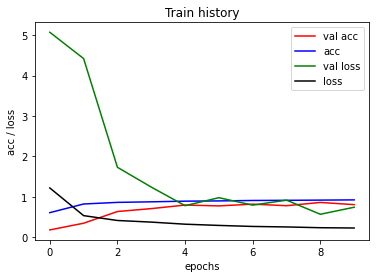

In [25]:
# Plot the training history for accuracy and validation loss
# Access the daata wiht history.history
# Maybe dropout makes it harder during train then for validation. Might explain
# why acc < val_acc

plt.plot(history.history['val_accuracy'], color = 'red', label = "val acc")
plt.plot(history.history['accuracy'], color = 'blue', label = "acc")
plt.plot(history.history['val_loss'], color = 'green', label = "val loss")
plt.plot(history.history['loss'], color = 'black', label = "loss")
plt.ylabel('acc / loss')
plt.xlabel('epochs')
plt.title('Train history')
plt.legend()

plt.show()


In [26]:
# Load the best saved model

best_model = load_model(model_save_path)

In [27]:
# Make predictions on the validation set

y_pred = best_model.predict(X_val)

# np.argmax() will return the index of the array where the values was the highest

y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_val, axis = 1)

In [28]:
# See the result in a confusion matrix

cm = confusion_matrix(y_true, y_pred_classes)
cm

array([[ 87,   2,   0,   1,   0,   3,   3,   0,   0,   0],
       [  0, 113,   1,   0,   0,   0,   1,   0,   0,   0],
       [  0,   1,  77,   1,   1,   4,   7,   2,   0,   0],
       [  0,   0,   0,  86,   0,  19,   1,   0,   5,   2],
       [  0,   1,   0,   0, 101,   0,   2,   2,   0,  11],
       [  0,   1,   0,   3,   0,  78,   1,   5,   0,   0],
       [  1,   0,   1,   0,   1,   0,  95,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,  93,   0,   0],
       [  1,   3,   0,   3,   1,   5,  12,   2,  62,   2],
       [  0,   1,   0,   1,   5,   2,   0,  14,   1,  71]], dtype=int64)

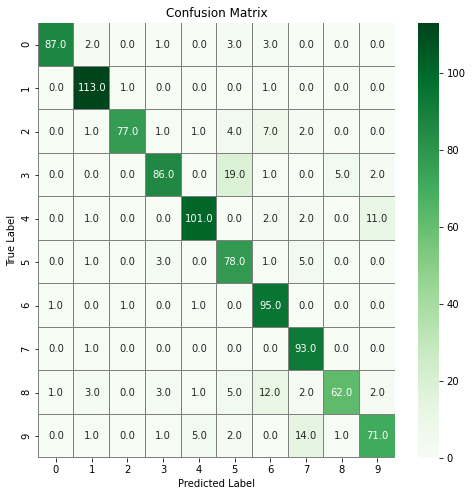

In [29]:
# plot the confusion matrix

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Classification report
# Target_names must be a be strings in a list

# Alt 1
target_list = [str(x) for x in np.arange(0,10)]

# Alt 2 
# target_list = ["0","1","2","3","4","5","6","7","8","9"]

# Create the classification report
# Accuracy and f1 -scores are high ~ 0.98

print(classification_report(y_true, y_pred_classes, target_names = target_list))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        96
           1       0.92      0.98      0.95       115
           2       0.97      0.83      0.90        93
           3       0.91      0.76      0.83       113
           4       0.93      0.86      0.89       117
           5       0.70      0.89      0.78        88
           6       0.78      0.97      0.86        98
           7       0.79      0.99      0.88        94
           8       0.91      0.68      0.78        91
           9       0.83      0.75      0.78        95

    accuracy                           0.86      1000
   macro avg       0.87      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000



In [31]:
# Predict 28 000 images from the test set

y_test_pred = best_model.predict(X_test)

[8.0250642e-09 2.9313662e-07 9.9994409e-01 4.7693353e-05 6.9736266e-09
 2.5865296e-07 6.8255022e-06 8.1010211e-07 3.0999999e-08 5.0703401e-09]
2


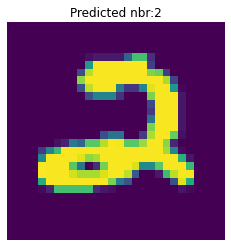

In [32]:
# Look at the image at index 0 in the test set

X_test2 = pd.read_csv('test.csv').values
image = X_test2[0] 
image = image.reshape(28,28)

# Look at the prediction of that image
# I can see that the probalibilty is the highest at index 2
# so its predicted as a number 2

print(y_test_pred[0])
print(np.argmax(y_test_pred[0]))

# Plot the image to verify
# Its a number 2, the prediction was correct

pred_nbr = np.argmax(y_test_pred[0])
plt.imshow(image)
plt.title("Predicted nbr:" + str(pred_nbr))
plt.axis('off')
plt.show()

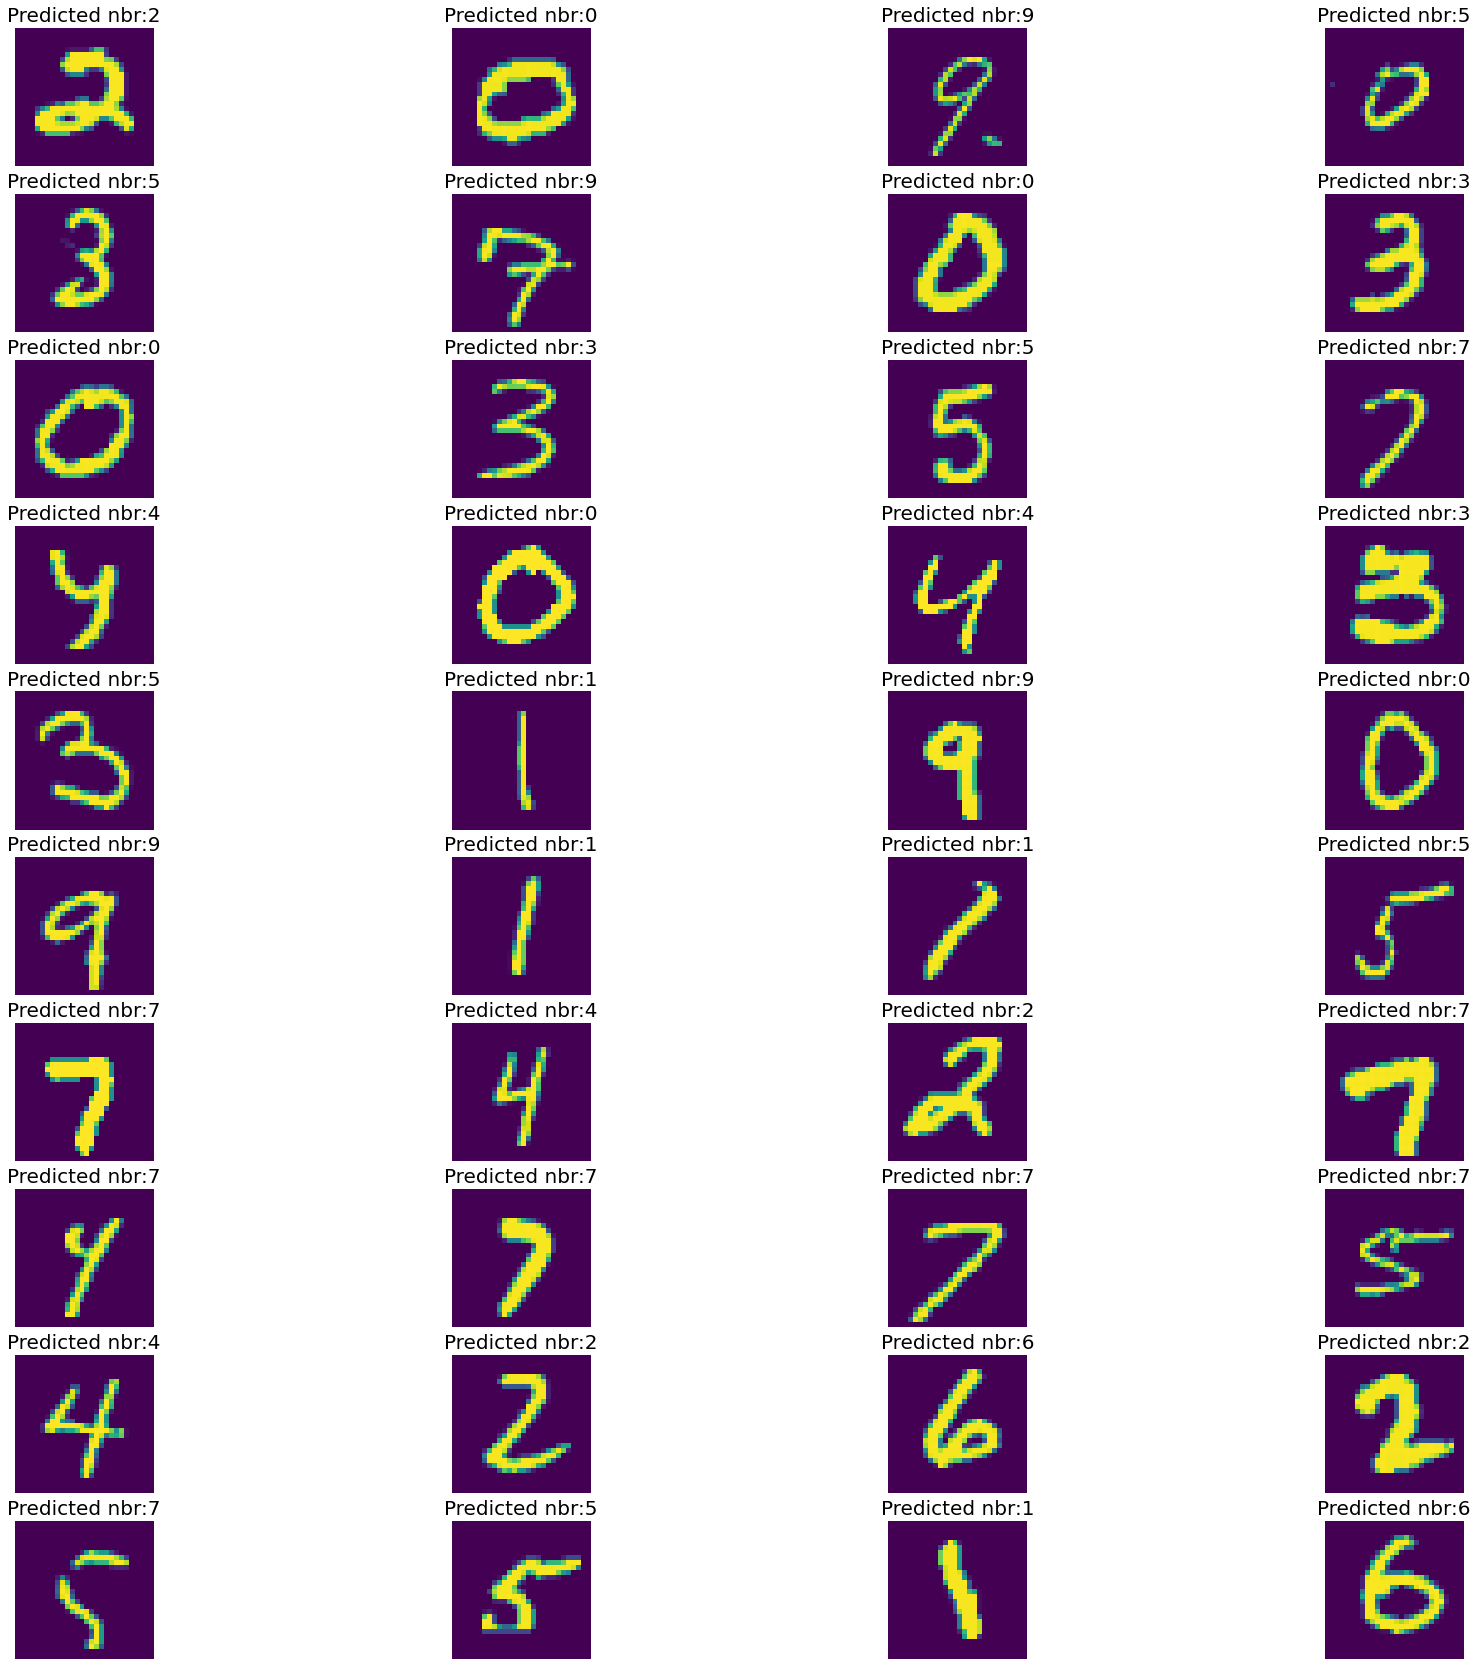

In [33]:
# Plot 40 test images and see if they are correct
# Create subplots
# 39 of 40 is correct 98 %
# 32 of 40 is correct with transfer learning 5000 images 80 %
# 34 of 40 is correct with transfer learning 10 000 images 85 %

   
fig, ax = plt.subplots(10,4,figsize = (30,30))

counter = 0

for i in range(10):
    for j in range(4):
        pred_nbr = np.argmax(y_test_pred[counter])
        
        image = X_test2[counter] 
        image = image.reshape(28,28)
        ax[i,j].imshow(image)
        ax[i,j].set_title("Predicted nbr:" + str(pred_nbr), fontsize= 20)
        ax[i,j].axis('off')
        counter += 1     